# Baseline model
As mentioned in our project proposal, our baseline model will be a random forest classifier trained with scikit-learn.

In [5]:
# package imports
import numpy as np
import matplotlib.pyplot as plt
import joblib
from PIL import Image
import cv2

# need pip install sklearn
try: # x86-64 specific sklearn acceleration, assume intelex=2023.3, sklearn=1.4
    from sklearnex import patch_sklearn
    patch_sklearn()
except (AttributeError, ModuleNotFoundError) as e:
    print('x86 patch error, defaulting to regular sklearn')

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.feature import hog

try: # CUDA-specific install if running on Colab
    %load_ext cudf.pandas
except ModuleNotFoundError:
    print('CuDF not installed, defaulting to regular pandas')
import pandas as pd

CuDF not installed, defaulting to regular pandas


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


## Data loading and preparation

In [59]:
# load Pickle object and get a sense of what we're working with
images = joblib.load('../data/set.pkl')
labels = np.unique(images['Genus'])
print('keys:', images.keys())
print('labels:', labels)
print('image sizes:', images['Image'][0].shape)

keys: Index(['Path', 'Genus', 'Image'], dtype='object')
labels: ['Auricularia' 'Cookeina' 'Entoloma' 'Fomitiporia' 'Geastrum' 'Hygrocybe'
 'Hymenochaete' 'Marasmius' 'Ophiocordyceps' 'Oudemansiella' 'Phallus'
 'Pluteus' 'Schizophyllum' 'Trametes' 'Xylaria']
image sizes: (15,)


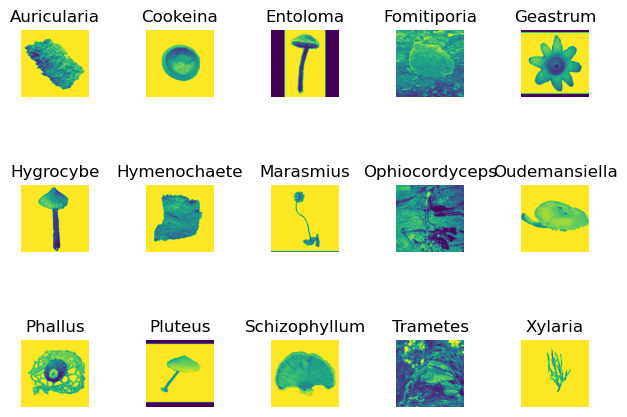

In [62]:
# randomly display one instance of each class
fig, axes = plt.subplots(nrows=3, ncols=5)
fig.tight_layout()

for axis, label in zip(axes.flat, labels):
    first_ind = images[images['Genus'] == label]
    axis.imshow(first_ind.loc[0, 'Image'])
    axis.axis('off')
    axis.title.set_text(label)

In [85]:
def hog_features(image):
    """
    Extracts features from an image by using histogram of oriented gradients (HOG).
    This boosts performance for traditional non-CNN statistical learning techniques.
    :param image: that we apply HOG onto
    :return: extracted features
    """
    features = hog(image, orientations=8, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    return features

def extract_features(data) -> list:
    """
    Wrapper for HOG feature extraction function.
    :param data: array of data
    :return: array of HOG-generated features
    """
    x_features = []
    for ind, img in enumerate(data):
        x_features.append(hog_features(img))
    return x_features

In [86]:
# splitting dataset into training/testing
test_size = 0.2 # change if needed

x = np.array(images['Image']) # x: data
y = np.array(images['Genus']) # y: label
x_train_pre, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, shuffle=True) # use default random state
x_train = extract_features(x_train_pre)
print('Training set size:', len(x_train_pre))
print('Test set size:', len(x_test))

Training set size: 5513
Test set size: 1379


## Training and tuning

In [11]:
def train(features_x, labels_y, classifier: str = 'SVC'):
    """
    :param features_x: 2D array of features/data points
    :param labels_y: 1D array of target values/labels to be predicted
    :param classifier: string name for the classifier. accepts 'RandomForestClassifier', 'SVC'
    :return: The classifier itself
    """
    if classifier == 'RandomForestClassifier':
        rf = RandomForestClassifier(n_estimators=500)
        rf.fit(features_x, labels_y)
        return rf
    elif classifier == 'SVC':
        svc = SVC()
        svc.fit(features_x, labels_y)
    else:
        raise ValueError("Invalid model type passed for training")

## Performance metrics

In [ ]:
# TODO: actually finish this
print(classification_report())